# Assignment 2 -- ML4F 2021

## Instructions

* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment2_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment2_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`.
* Do not spend time on optimizing the speed of your code. 
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples,silhouette_score

## Introduction

The Paycheck Protection Program (PPP) gives support to companies who are negatively impacted by Covid-19 to pay their employees. Many businesses have been affected and the money was limited. This means the PPP cannot give all the companies money. The dataset provided contains the loans to different companies. It also contains the probability of default (`ProbabilityDefault`) as estimated by the loan officer.

Let's load and have a look at the data.

In [2]:
path = os.path.join('data','loans.xlsx')

df_data = pd.read_excel(path)

# Question 1
(12 points)

Use the methods discussed so far to preprocess the data. Make some descriptive statistics and histograms etc to find out more about the distributions of the data. Are there NaNs, outliers etc? Then choose what preprocessing to apply and clearly explain your choices.

In [3]:
df_data.dtypes

LoanAmount             object
City                   object
State                  object
Zip                     int64
NAICSCode             float64
BusinessType           object
RaceEthnicity          object
Gender                 object
Veteran                object
NonProfit              object
JobsRetained          float64
DateApproved           object
Lender                 object
CD                     object
AgeLoan                 int64
ProbabilityDefault    float64
dtype: object

In [4]:
df_data['LoanAmount'] = pd.to_numeric(df_data['LoanAmount'],errors='coerce')

array([[<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Zip'}>],
       [<AxesSubplot:title={'center':'NAICSCode'}>,
        <AxesSubplot:title={'center':'JobsRetained'}>],
       [<AxesSubplot:title={'center':'AgeLoan'}>,
        <AxesSubplot:title={'center':'ProbabilityDefault'}>]],
      dtype=object)

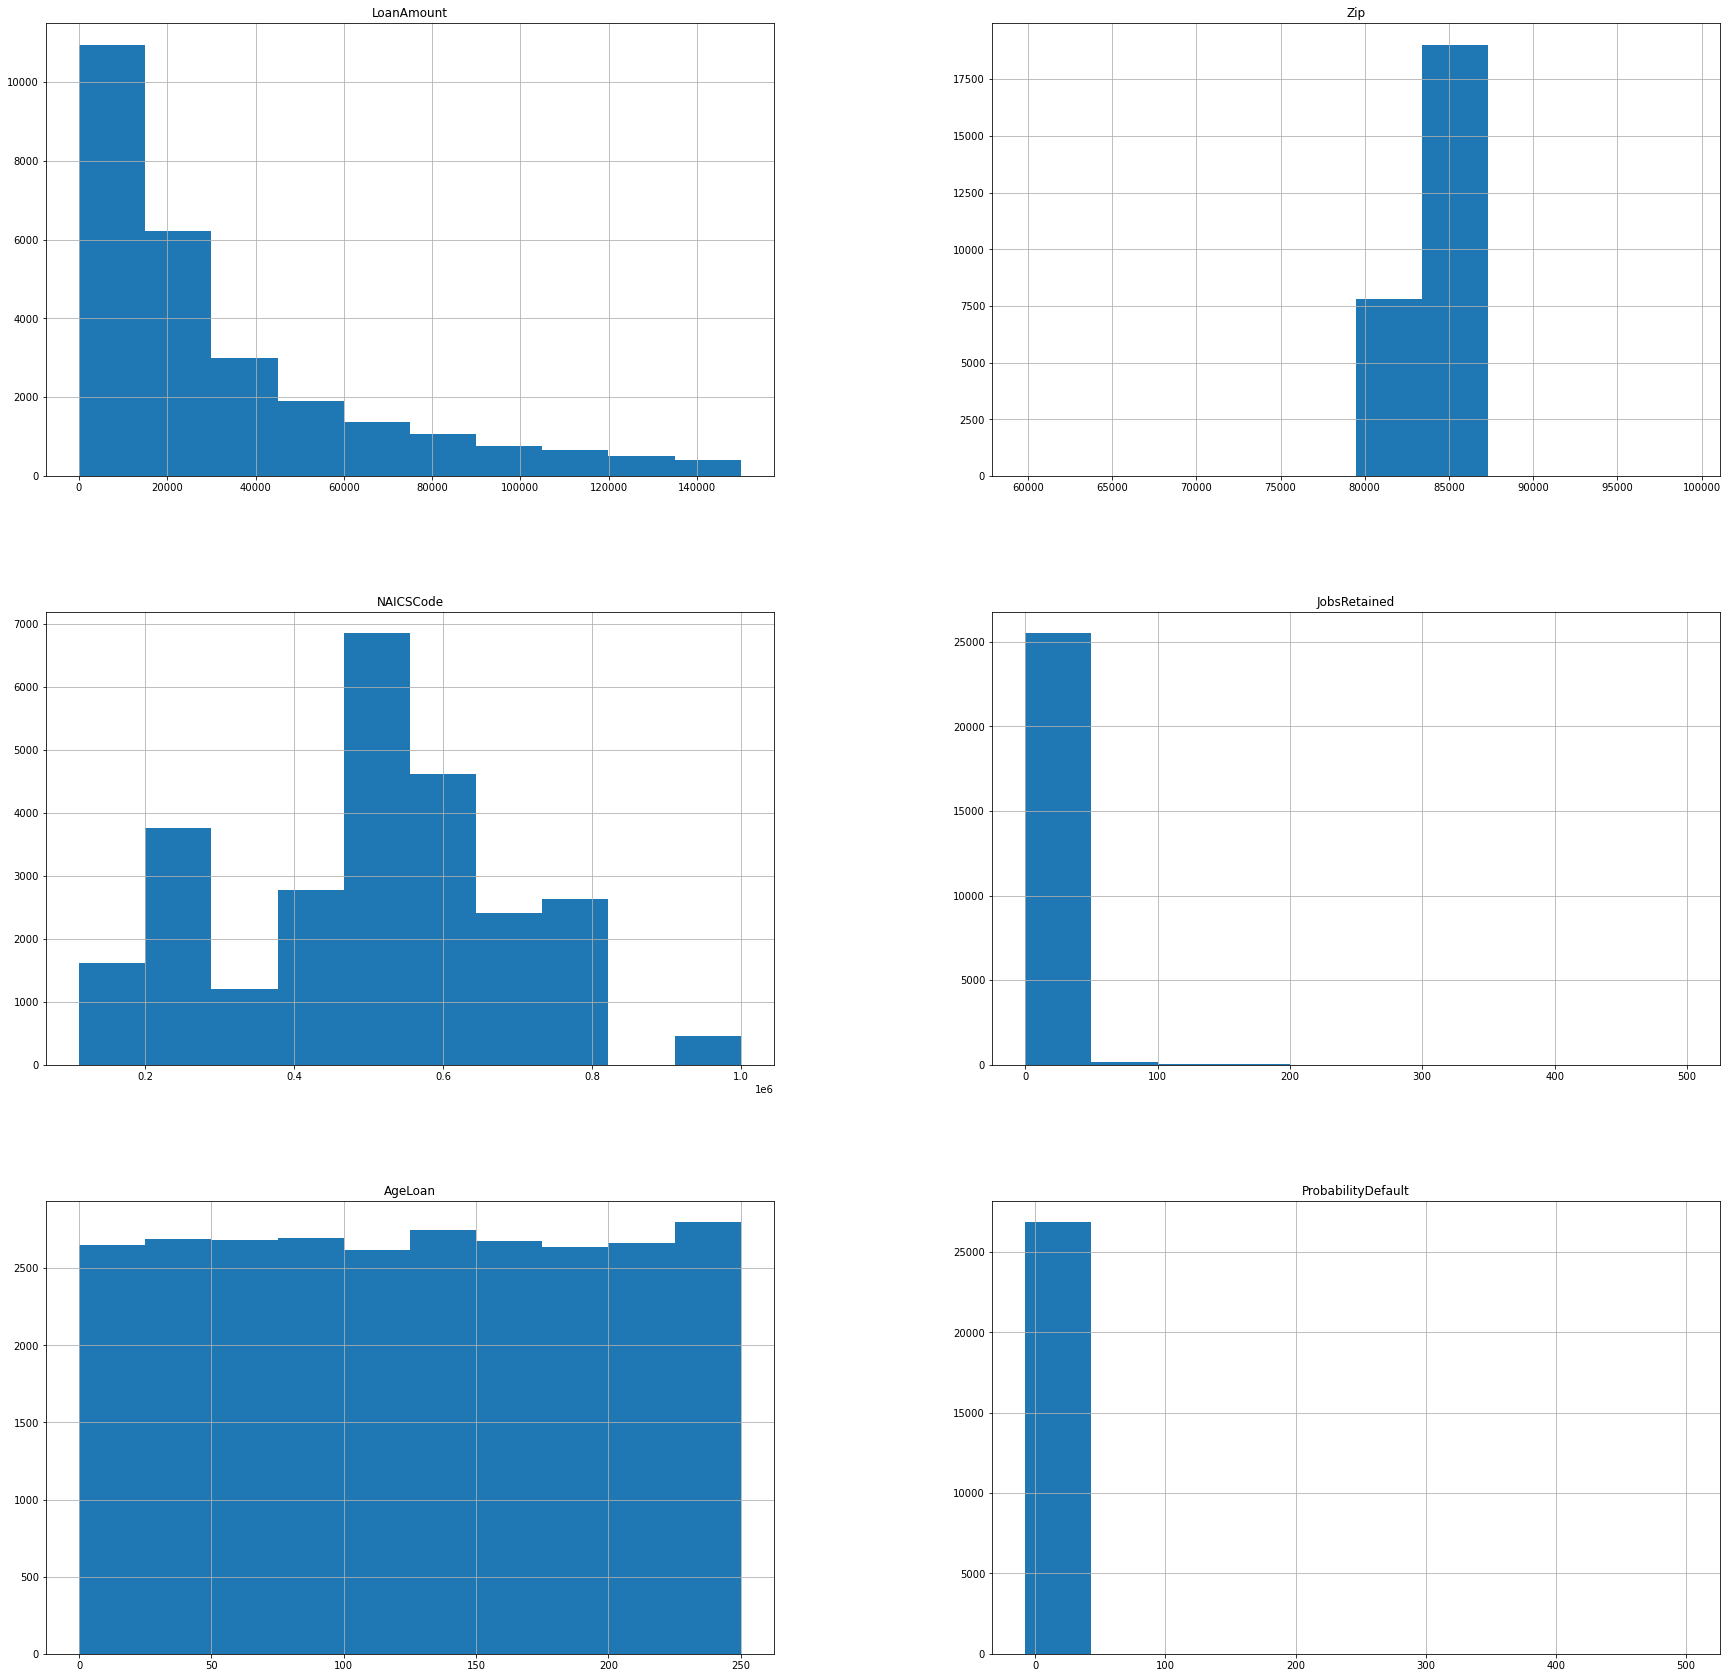

In [5]:
df_data.hist(figsize=(30,30))

In [6]:
stats = pd.DataFrame(df_data.describe(include='all'))
stats

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
count,26852.000000,26855,26855,26855.000000,26333.000000,26838,26855,26855,26855,517,25780.000000,26855,26855,26855,26855.000000,26855.000000
unique,NaN,352,1,NaN,NaN,15,6,3,3,1,NaN,77,289,4,NaN,NaN
top,NaN,BOISE,ID,NaN,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,Y,NaN,04/28/2020,Idaho Central CU,ID - 01,NaN,NaN
freq,NaN,4949,26855,NaN,NaN,11049,24308,21450,22872,517,NaN,3577,3617,14370,NaN,NaN
mean,32639.463601,NaN,NaN,83573.683076,510319.572400,NaN,NaN,NaN,NaN,NaN,5.651862,NaN,NaN,NaN,124.983132,3.244025
std,33270.802106,NaN,NaN,309.367113,203553.540773,NaN,NaN,NaN,NaN,NaN,15.293767,NaN,NaN,NaN,72.430690,3.821607
min,52.000000,NaN,NaN,59847.000000,111110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,-7.566606
25%,8847.500000,NaN,NaN,83402.000000,423110.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,62.000000,1.558186
50%,20143.210000,NaN,NaN,83642.000000,532412.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,125.000000,2.732590
75%,44800.000000,NaN,NaN,83706.000000,621399.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,188.000000,4.342069


In [7]:
df_data.isna().sum()

LoanAmount                3
City                      0
State                     0
Zip                       0
NAICSCode               522
BusinessType             17
RaceEthnicity             0
Gender                    0
Veteran                   0
NonProfit             26338
JobsRetained           1075
DateApproved              0
Lender                    0
CD                        0
AgeLoan                   0
ProbabilityDefault        0
dtype: int64

In [8]:
#Dropping NaN values in Business type variable --> loosing only 17 observations.
df_data = df_data.dropna(subset=['BusinessType'])

In [9]:
#First filling NaN values into N --> It is a yes/no question/answer. After making a dummy variable.
#Yes answers are changed into 1 and no into 0.
df_data['NonProfit'] = df_data['NonProfit'].fillna('N')

In [10]:
# Non-defined industries are put to 100000 --> Could be a factor that explains default.
df_data['NAICSCode'] = df_data['NAICSCode'].fillna(100000)

In [11]:
#Filling median into Nan Values in the variable Jobs retained
df_data = df_data.fillna(df_data.median())

In [12]:
df_data_w = df_data[['JobsRetained','ProbabilityDefault']]

In [13]:
def using_mstats_df(df):
    return df.apply(using_mstats, axis=0)

def using_mstats(s):
    return mstats.winsorize(s, limits=[0.05, 0.05])

In [14]:
df_data[['JobsRetained','ProbabilityDefault']] = using_mstats_df(df_data_w)

In [15]:
stats2 = pd.DataFrame(df_data.describe(include='all'))
stats2

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
count,26838.000000,26838,26838,26838.000000,26838.000000,26838,26838,26838,26838,26838,26838.000000,26838,26838,26838,26838.000000,26838.000000
unique,NaN,352,1,NaN,NaN,15,6,3,3,2,NaN,77,289,4,NaN,NaN
top,NaN,BOISE,ID,NaN,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,N,NaN,04/28/2020,Idaho Central CU,ID - 01,NaN,NaN
freq,NaN,4947,26838,NaN,NaN,11049,24291,21433,22855,26321,NaN,3575,3617,14364,NaN,NaN
mean,32635.632670,NaN,NaN,83573.714882,502398.874581,NaN,NaN,NaN,NaN,NaN,4.244653,NaN,NaN,NaN,124.982823,3.146409
std,33265.179542,NaN,NaN,309.445856,209332.357212,NaN,NaN,NaN,NaN,NaN,5.259703,NaN,NaN,NaN,72.432453,1.982160
min,52.000000,NaN,NaN,59847.000000,100000.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.571031
25%,8842.500000,NaN,NaN,83402.000000,333992.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,62.000000,1.558024
50%,20150.000000,NaN,NaN,83642.000000,531320.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,125.000000,2.732433
75%,44800.000000,NaN,NaN,83706.000000,621340.000000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,188.000000,4.341942


array([[<AxesSubplot:title={'center':'LoanAmount'}>,
        <AxesSubplot:title={'center':'Zip'}>],
       [<AxesSubplot:title={'center':'NAICSCode'}>,
        <AxesSubplot:title={'center':'JobsRetained'}>],
       [<AxesSubplot:title={'center':'AgeLoan'}>,
        <AxesSubplot:title={'center':'ProbabilityDefault'}>]],
      dtype=object)

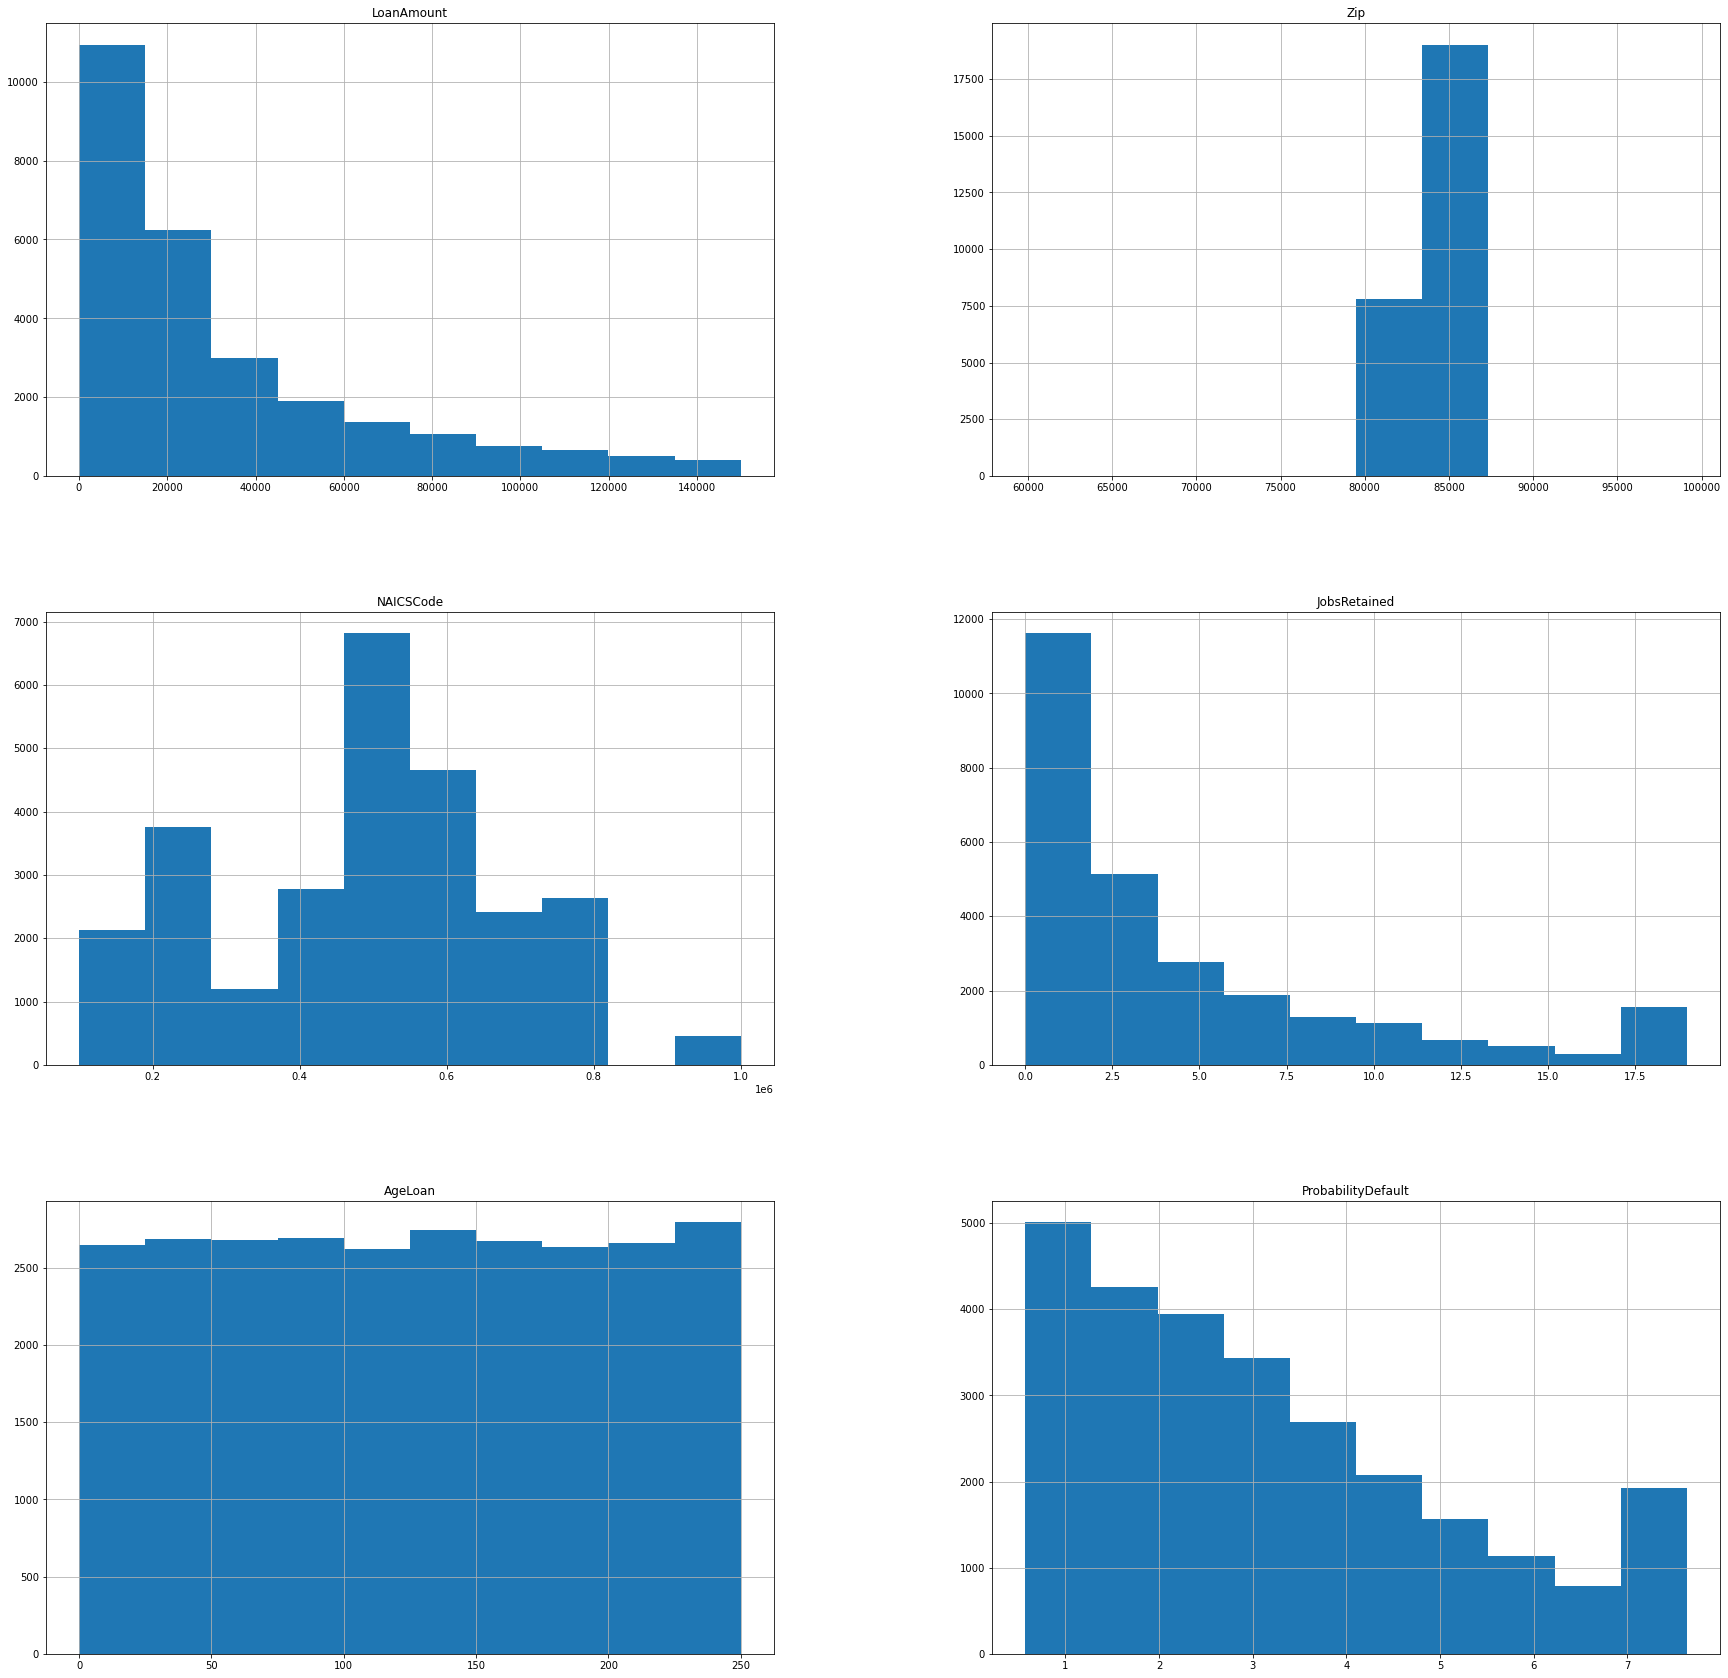

In [16]:
df_data.hist(figsize=(30,30))

# Question 2
(22 points)

Explain what a k-means model is.

- In a k-means model, a number of centroids are identified by input k. While keeping the centroids as small as possible, the model will allocate every data point to the nearest cluster. 

Estimate a k-means model with 3 clusters for the variables `LoanAmount`, `Zip`, `ProbabilityDefault` and `AgeLoan`.

In [17]:
df_data_kmeans=df_data[['LoanAmount', 'Zip', 'ProbabilityDefault', 'AgeLoan']]

In [18]:
Kmean = MiniBatchKMeans(n_clusters=3, random_state=25)

In [19]:
Kmean.fit(df_data_kmeans)

MiniBatchKMeans(n_clusters=3, random_state=25)

In [20]:
Kmean.cluster_centers_

array([[4.97404881e+04, 8.35592086e+04, 4.35031851e+00, 1.91388571e+02],
       [1.26084058e+04, 8.35676921e+04, 2.12097586e+00, 7.93224719e+01],
       [1.06805710e+05, 8.35912688e+04, 6.53076963e+00, 2.33612500e+02]])

In [21]:
y_kmeans=Kmean.predict(df_data_kmeans)

Determine with the elbow method with inertia what the right number of clusters is. Please plot the inertia and explain your choice of clusters.

In [22]:
inertia_list = []
for num_clusters in range(1, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(df_data_kmeans)
    inertia_list.append(kmeans_model.inertia_)

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

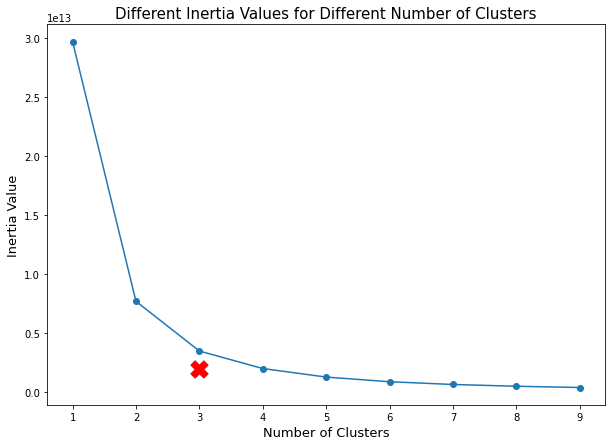

In [23]:
plt.figure(figsize=(10,7))
plt.plot(range(1,10),inertia_list)
plt.scatter(range(1,10),inertia_list)
plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=15)

In [24]:
Kmean.labels_

array([1, 2, 0, ..., 1, 1, 2], dtype=int32)

- Based on the inertia, 3 clusters is optimal because more clusters will not improve a lot.

Do the same but this time using the silhouette score. Compare both. Would you now reconsider your choice of the previous question?

In [257]:
silhouette_s = []
for num_clusters in range(2, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, #init="k-means++"
                         )
    kmeans_model.fit(df_data_kmeans)
    silhouette_sc = silhouette_score(df_data_kmeans, kmeans_model.labels_)
    silhouette_s.append(silhouette_sc)

In [258]:
silhouette_s

[0.7181478247131723,
 0.6588920482930182,
 0.6177498823329992,
 0.585395359537324,
 0.5807675455185146,
 0.5756167373714624,
 0.5627008520140812,
 0.5486782221173915]

Text(0.5, 1.0, 'Different Silhoulette Scores for Different Number of Clusters')

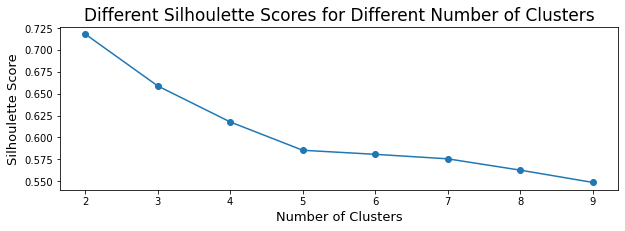

In [259]:
plt.figure(figsize=(10,3))
plt.plot(range(2,10),silhouette_s)
plt.scatter(range(2,10),silhouette_s)
# plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Silhoulette Score", size=13)
plt.title("Different Silhoulette Scores for Different Number of Clusters", size=17)

### anwer: reconsider choice in comparison to PCA

# Question 3

(22 points)

Mention one advantage and one disadvantage of using Principal Component Analysis (PCA).

- An advantage of PCA is that improves visualization of the data by reducing it to two dimensions. 
- An disadvantage of PCA is that the independent variables become less interpretable

Reduce the dataset to two dimensions with PCA and make a clear plot. Make sure to label all the important information.

In [28]:
df_PCA= df_data

In [29]:
df_PCA.dtypes

LoanAmount            float64
City                   object
State                  object
Zip                     int64
NAICSCode             float64
BusinessType           object
RaceEthnicity          object
Gender                 object
Veteran                object
NonProfit              object
JobsRetained          float64
DateApproved           object
Lender                 object
CD                     object
AgeLoan                 int64
ProbabilityDefault    float64
dtype: object

In [30]:
df_features_num = df_PCA.loc[:,df_PCA.dtypes != object]
df_features_cat = df_PCA.loc[:, df_PCA.dtypes == object]

In [70]:
scaler = StandardScaler()
features = df_features_num.columns
df_features_numstd = scaler.fit_transform(df_features_num)
df_features_numstd = pd.DataFrame(data=df_features_numstd, columns = features)

In [260]:
df_features_numstd

,LoanAmount,Zip,NAICSCode,JobsRetained,AgeLoan,ProbabilityDefault
0,-0.355803,0.136650,0.137636,-0.807029,-0.110213,-0.956268
1,1.423869,0.844380,1.051516,2.805410,1.449891,1.456661
2,1.288590,-0.558153,1.474822,0.523870,1.532728,-0.409555
3,3.032187,0.905782,1.050082,2.805410,1.587953,2.265744
4,-0.734975,-0.425656,-0.833178,-0.616900,-1.021423,-0.849404
...,...,...,...,...,...,...
26833,0.792566,0.421035,-0.086892,1.094255,1.505115,0.951162
26834,-0.698510,-0.496752,-1.865016,-0.046515,-0.772911,-0.321843
26835,-0.079232,-0.832843,-0.273632,1.664640,0.400618,0.189086
26836,-0.578442,-0.716503,0.185933,-0.807029,-0.386337,-0.492198


In [261]:
df_features_numstd.drop(columns=['ProbabilityDefault'], inplace=True)

In [54]:
#df_features_numstd.drop(columns=['NAICSCode'], inplace=True)

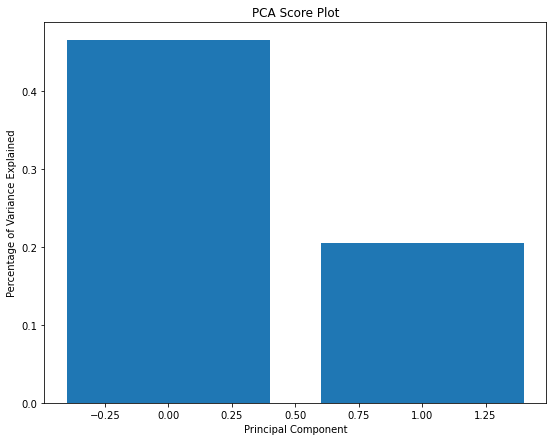

In [262]:
pca = PCA(n_components=2).fit(df_features_numstd)

plt.figure(figsize=(9,7))
plt.bar(range(pca.n_components), pca.explained_variance_ratio_)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Score Plot')
plt.show()

In [263]:
pca.explained_variance_ratio_

array([0.4647946 , 0.20557214])

In [264]:
df_features_pca = pd.DataFrame(pca.transform(df_features_numstd))
df_features_pca.index=df_features_num.index

In [265]:
df_features_pca.columns = [f'pca.{i}' for i in df_features_pca.columns]

In [59]:
df_features_num1 = pd.concat([df_features_num, df_features_pca], axis=1)

This time reduce the dataset to two dimensions with t-SNE and make a clear plot.

In [267]:
tsne = TSNE(n_components=2, random_state=25, n_iter=300)
tsne_results = tsne.fit_transform(df_features_numstd)
print(tsne_results)

[[ 2.8302047  -7.60342   ]
 [ 2.7388263   7.428717  ]
 [ 3.0198739   4.0974574 ]
 ...
 [-0.6032079   0.3594247 ]
 [-2.2547016  -4.000586  ]
 [ 0.87682694  8.564748  ]]


In [268]:
df_features_num1['tsne-2d-one'] = tsne_results[:,0]
df_features_num1['tsne-2d-two'] = tsne_results[:,1]

Text(0.5, 1.0, 'PCA')

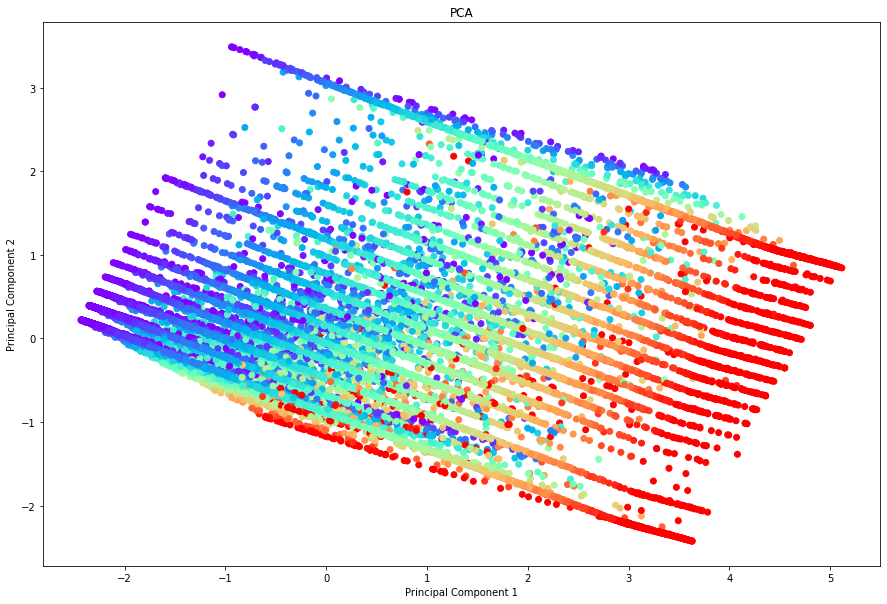

In [266]:
plt.figure(figsize=(15,10))
plt.scatter(x=df_features_num1['pca.0'], y=df_features_num1['pca.1'],
            c=df_features_num1['ProbabilityDefault'],cmap='rainbow')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('PCA')

Text(0.5, 1.0, 't-sne')

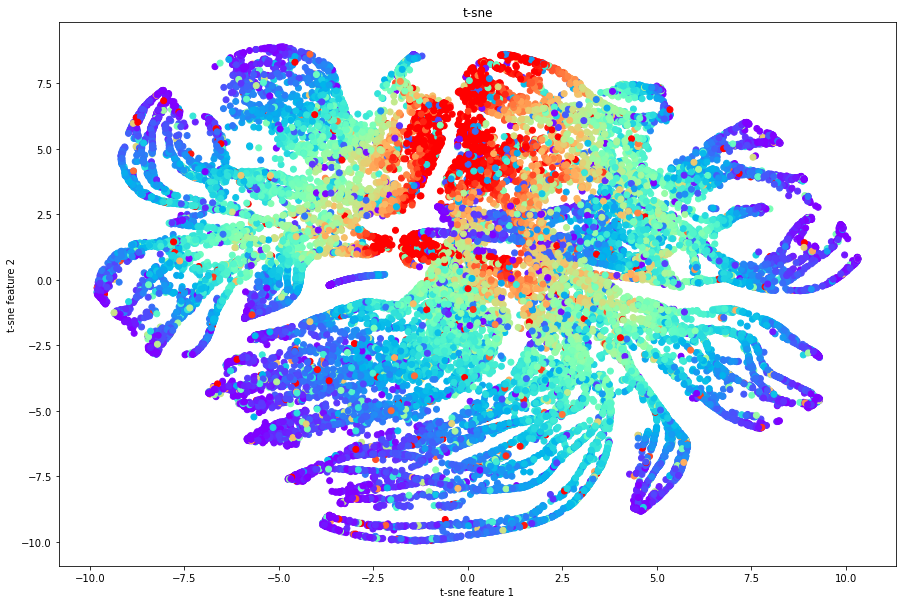

In [269]:
plt.figure(figsize=(15,10))
plt.scatter(x=df_features_num1['tsne-2d-one'], y=df_features_num1['tsne-2d-two'],
            c=df_features_num1['ProbabilityDefault'],cmap='rainbow')
plt.ylabel('t-sne feature 2')
plt.xlabel('t-sne feature 1')
plt.title('t-sne')

Explain whether PCA or t-SNE is better to use with this particular data set.

#### Answer:

# Question 4

(22 points)

Add the two columns you made with PCA to the dataset. Then pick a Decision Tree model and train a good model to predict the Probability of Default (`ProbabilityDefault`). It is not necessary to tune the hyperparameters (so the default settings are fine). 

In [270]:
correlation_matrix = df_features_num1.corr()
# Setting the style of the matrix
correlation_matrix.style.background_gradient(cmap='Blues')

,LoanAmount,Zip,NAICSCode,JobsRetained,AgeLoan,ProbabilityDefault,pca.0,pca.1,pca.2,pca.3,tsne-2d-one,tsne-2d-two
LoanAmount,1.000000,-0.009196,-0.052738,0.559661,0.867231,0.788611,0.937838,-0.131380,-0.173693,0.270241,0.048971,0.440958
Zip,-0.009196,1.000000,0.031970,-0.066952,-0.002553,0.001770,-0.018813,-0.076211,-0.002529,-0.007418,0.185104,-0.138237
NAICSCode,-0.052738,0.031970,1.000000,0.023272,-0.072090,-0.052897,-0.048469,0.080479,0.028177,0.030292,0.743454,-0.109739
JobsRetained,0.559661,-0.066952,0.023272,1.000000,0.532720,0.470779,0.709007,0.703111,0.052402,-0.014046,0.101562,0.559524
AgeLoan,0.867231,-0.002553,-0.072090,0.532720,1.000000,0.774336,0.926863,-0.164061,-0.237581,-0.239924,0.100589,0.409293
ProbabilityDefault,0.788611,0.001770,-0.052897,0.470779,0.774336,1.000000,0.884824,-0.252294,0.390980,-0.023854,0.059386,0.359971
pca.0,0.937838,-0.018813,-0.048469,0.709007,0.926863,0.884824,1.000000,-0.000000,-0.000000,-0.000000,0.087200,0.498682
pca.1,-0.131380,-0.076211,0.080479,0.703111,-0.164061,-0.252294,-0.000000,1.000000,0.000000,-0.000000,0.055614,0.294767
pca.2,-0.173693,-0.002529,0.028177,0.052402,-0.237581,0.390980,-0.000000,0.000000,1.000000,-0.000000,-0.015949,-0.015566
pca.3,0.270241,-0.007418,0.030292,-0.014046,-0.239924,-0.023854,-0.000000,-0.000000,-0.000000,1.000000,-0.104621,0.034408


In [61]:
dct_dummies = {}

for cat, sr in df_features_cat.iteritems():
    df_dummies = pd.get_dummies(sr.astype('category'))
    df_dummies.columns = [f'cat.{cat}.{c}' for c in df_dummies]
    dct_dummies[cat] = df_dummies.iloc[:,1:] # drop one to avoid multicollinearity

In [62]:
df_features_dummies = pd.concat(dct_dummies.values(), axis=1)
print(np.shape(df_features_dummies))

(26838, 742)


In [63]:
df_const = pd.DataFrame(index=df_features_dummies.index, columns=['const'])
df_const = df_const.fillna(1)
print(df_const)

       const
0          1
1          1
2          1
3          1
4          1
...      ...
26850      1
26851      1
26852      1
26853      1
26854      1

[26838 rows x 1 columns]


In [64]:
df_features = pd.concat([
    df_const,
    df_features_dummies, 
    df_features_num, 
], axis=1)

print(df_features)

       const  cat.City.29961 N SPIRIT LAKE  cat.City.ABERDEEN  \
0          1                             0                  0   
1          1                             0                  0   
2          1                             0                  0   
3          1                             0                  0   
4          1                             0                  0   
...      ...                           ...                ...   
26850      1                             0                  0   
26851      1                             0                  0   
26852      1                             0                  0   
26853      1                             0                  0   
26854      1                             0                  0   

       cat.City.ACEQUIA  cat.City.ALBION  cat.City.ALMO  \
0                     0                0              0   
1                     0                0              0   
2                     0                0  

In [65]:
df_features_norm = df_features / np.linalg.norm(df_features, ord=2, axis=0)

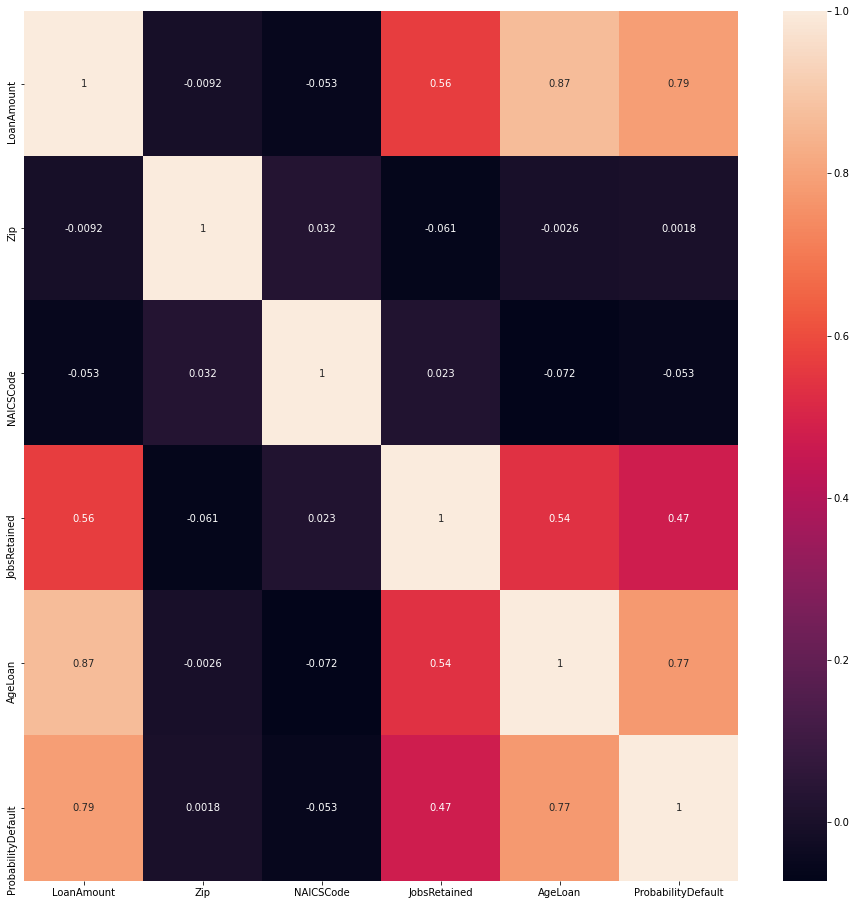

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the seaborn heatmap 
fig = plt.figure(figsize=[16,16])
sns.heatmap(df_data.corr(), annot=True)
plt.show()

In [67]:
x = df_features_num1[['pca.0','LoanAmount', 'JobsRetained','AgeLoan' ]]
x = x.merge(df_features_norm, left_index=True, right_index=True)

In [68]:
## Your answer
#x = df_features_num1[['pca.0','LoanAmount', 'JobsRetained','AgeLoan' ]]
y = df_features_num1[['ProbabilityDefault']]

In [69]:
#Split the data into training and test set (both x and y variables)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=25)

In [70]:
base_tree = tree.DecisionTreeRegressor(random_state=25)

In [71]:
base_tree = base_tree.fit(x_train, y_train)

In [72]:
y_predict = base_tree.predict(x_test)

In [73]:
r_square = metrics.r2_score(y_test,y_predict)
r_square

0.9999997517220497

Explain how well your model performs. Do you think the predictions are any good? 

BLABLABLA

# Question 5

(22 points)

This question turns on how to tune hyperparameters. Please compute what you consider the best choice for "splitter", "max_depth", and "min_samples_leaf" (jointly).

In [210]:
base_tree.get_depth()

34

In [252]:
adv_tree=tree.DecisionTreeRegressor(random_state=25, max_depth=35, splitter="random" , min_samples_leaf=1)

In [253]:
adv_tree = adv_tree.fit(x_train, y_train)

In [254]:
y_predict = adv_tree.predict(x_test)

In [255]:
r_square = metrics.r2_score(y_test,y_predict)
r_square

0.9782955620857703

Does your hyperparameter tuning does lead to overfitting? Provide arguments.

In [ ]:
## Your answer

Explain whether you consider the hyperparameter tuning useful (given amongst others the compute time, precision, other considerations, etc.).

In [ ]:
## Your answer

---